In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [12]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

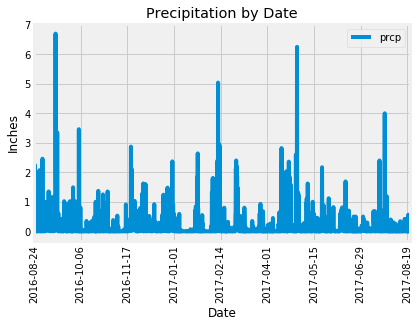

In [22]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

result = session.query(Measurement.date).order_by(Measurement.date.desc()).first() # This gives us 2017-08-23

# Calculate the date 1 year ago from the last data point in the database

dateStr = result[0]
last_date = datetime.strptime(dateStr,'%Y-%m-%d')

year_ago = last_date - dt.timedelta(days=365)
year_ago_str = datetime.strftime(year_ago,'%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
query = (session
         .query(Measurement.date, Measurement.prcp)
         .filter(Measurement.date > year_ago_str))

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.read_sql_query(query.statement,session.get_bind(),index_col='date')

# Sort the dataframe by date
df = df.dropna()
df = df.sort_values(by=['date'])
# Use Pandas Plotting with Matplotlib to plot the data
df.plot()
plt.title("Precipitation by Date")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation=90)
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
result = session.query(Measurement.station).distinct(Measurement.station).count()
print(result)

9


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stationQuery = (session
                 .query(Measurement.station, func.count(Measurement.station))
                 .group_by(Measurement.station)
                 .order_by(func.count(Measurement.station).desc()))
result = engine.execute(stationQuery.statement).fetchall()
for r in result:
    print(r)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
mostActiveStation = result[0][0]
tempQuery = (session
              .query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs))
              .filter(Measurement.station == mostActiveStation))
tempResults = engine.execute(tempQuery.statement).fetchall()
print(f"Most active station ID: {mostActiveStation}")
print(f"Lowest temperature: {tempResults[0][0]}")
print(f"Highest temperature: {tempResults[0][1]}")
print(f"Average temperature: {tempResults[0][2]}")

Most active station ID: USC00519281
Lowest temperature: 54.0
Highest temperature: 85.0
Average temperature: 71.66378066378067


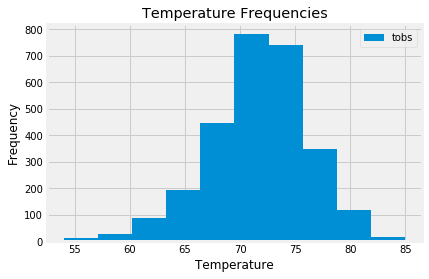

In [24]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tempStationQuery = (session
                 .query(Measurement.station, func.count(Measurement.tobs))
                 .group_by(Measurement.station)
                 .order_by(func.count(Measurement.station).desc()))
tsResult = engine.execute(tempStationQuery.statement).fetchall()
mostStation = tsResult[0][0] # in case this changes from the above somehow

dateQuery = (session
         .query(Measurement.date, Measurement.tobs)
         .filter(Measurement.station == mostStation))

df2 = pd.read_sql_query(dateQuery.statement,session.get_bind(),index_col='date')

# Sort the dataframe by date
df2 = df2.dropna()
df2 = df2.sort_values(by=['date'])
# Use Pandas Plotting with Matplotlib to plot the data
df2.plot.hist()
plt.title("Temperature Frequencies")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

## Bonus Challenge Assignment

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
